In [4]:
import pandas as pd
import os
from tqdm import tqdm

In [5]:
import warnings
warnings.filterwarnings("ignore")

# Introduction
Based on the task description and initial consultation, 
the assignment was to classify astronomical object from the perspective of data analyst standpoint.<br>
Hence, the project will focus on building the features base on the variables and analyse it using the relevant clustering analysis method / algorithm

# Data Engineering (converting txt file to pandas dataframe)

<p>As all the information about the objects are provided in the format of txt file.<br>
The first step is to build a function that simulate the data as one dataframe and export it as one csv file.<br>
The simulation steps are as follows : <br>

1. Set the directory of the text files
2. Import the os package and return the list of file names using the os method
3. Define a function to separate the white space between the column and return it as a list
4. Create a loop function to iterate all the txt files and append each object into a dataframe
5. Filter the relevant column as explained in the briefing
6. Return the total dataframe as .csv format 

A glimpse of the dataset is as follows:



In [6]:
DATA_DIR = 'astro-analytathon-master/astro-analytathon-master/data/'

In [7]:
files = os.listdir(DATA_DIR)
#list all the files in the Direction

In [8]:
files = list(filter(lambda file:".txt" in file, files))
#only return text file

In [9]:
header = '###MJD,m,dm,uJy,duJy,F,err,chi/N,RA,Dec,x,y,maj,min,phi,apfit,mag5sig,Sky,Obs'

header = header.split(",")

In [10]:
#define function to separate white space and differentiate each collumn in the text file
def fix_space_data(string):
    
    return string.replace("      "," ").replace("     "," ").replace("    "," ").replace("   "," ").replace("  "," ").split(" ")

In [14]:
#this loop takes time to run. 
#Using For loop to combine all the txt file, applying the function to recognize all the columns in the txt file
#ONLY RUN THIS IF REQUIRE NEW CSV FILE. if not proceed to DATA CLEANING AND EDA
df = pd.DataFrame()

index = 1
error_file = []
for file in files:
    
    try:
        df_raw = pd.read_csv(f"{DATA_DIR}{file}")
        df_temp = pd.DataFrame(df_raw.applymap(fix_space_data).iloc[:,0].tolist())
        df_temp.columns = header
        df_temp["Object"] = index
        df_temp['uuid'] = str(file)
        index += 1

        df = df.append(df_temp)
        
    except:
        
        print(file)
        error_file.append(file)

In [21]:
df1 = df

In [22]:
df1 = df1.reset_index().drop("index", axis = 1)

In [23]:
df1['uuid'] = df1['uuid'].astype(str)

In [24]:
df1['uuid'] = df1.uuid.str[20:24]

In [25]:
df1 = df1.iloc[:, [0,3,4,5,7,19,20]]

In [26]:
df1.head(5)

,###MJD,uJy,duJy,F,chi/N,Object,uuid
0,57248.473434,-125,92,c,0.94,1,2776
1,57248.491712,-84,113,c,1.16,1,2776
2,57248.524200,-220,359,c,0.98,1,2776
3,57248.550040,125,796,c,1.10,1,2776
4,57313.373363,-47,19,c,0.87,1,2776


In [147]:
df1.to_pickle("rawdata_final.pkl")

In [148]:
df1.to_csv("rawdata_final.csv")

# Data Cleaning and Exploratory Data Analysis

<p>The next important step towards clustering analysis is the preparation of dataset. <br>
Firstly, the data is investigated via Exploratory Data Analysis (EDA). <br>
A few variable plots are also visualised in order to further analyse the characteristic of the data.

In [27]:
rawdata = pd.read_csv("rawdata_final.csv")
rawdata = rawdata.reset_index().drop("Unnamed: 0", axis = 1).drop("index", axis = 1)
rawdata.iloc[:,[1,2,3,4]].describe()

,uJy,duJy,chi/N
count,9.478740e+05,9.478740e+05,9.477990e+05
mean,2.151482e+01,1.380813e+02,2.538846e+01
std,1.493705e+04,6.984684e+03,8.577409e+03
min,-4.237580e+06,0.000000e+00,-2.000000e+00
25%,-3.100000e+01,1.300000e+01,1.040000e+00
50%,-3.000000e+00,1.800000e+01,1.250000e+00
75%,2.100000e+01,3.000000e+01,1.610000e+00
max,1.043294e+07,2.964111e+06,7.322680e+06


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [29]:
null_data = rawdata[rawdata.isnull().any(axis=1)]
print("number of missing data:" , null_data.iloc[:,1].isnull().count())

number of missing data: 75


In [30]:
erdata = rawdata[rawdata["uuid"] == 2778]
xval = erdata['###MJD']
yval = erdata['uJy']
xerr = erdata['duJy']

Text(0.5, 1.0, 'ID 2778: MJD vs uJy Plot')

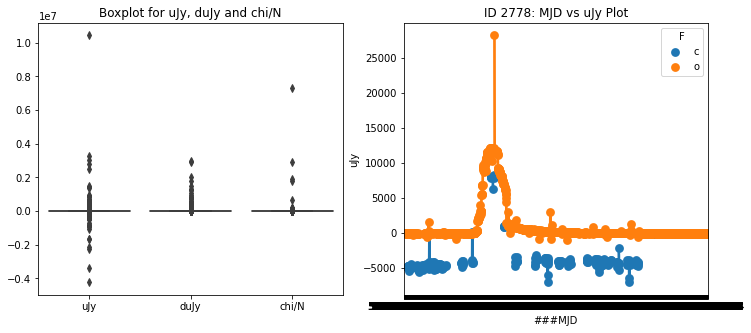

In [31]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
sns.boxplot(data=rawdata.iloc[:,[1,2,3,4]], ax = ax[0]).set_title("Boxplot for uJy, duJy and chi/N")
sns.pointplot(x=xval, y=yval, ci = xerr, data = erdata, capsize=3, ax = ax[1], hue = "F").set_title("ID 2778: MJD vs uJy Plot")

<p>Based from the EDA and the boxplot:<br>
    
1. Significant gap value of std and min,max and mean are observed.<br>
2. Presence of outliers for all the variable uJy, duJy and Chi/N<br>
3. Negative values are seen in "uJy" and "duJy"<br>
4. Extreme single high points / low points<br>

Thus, further data cleaning is required which includes: <br>

**1. Removing of outliers and extreme values**
    
- Dropping missing values
- Removing data for Chi/n more than 20,000 & negative values<br>
- Focusing on orange filter only<br>
- Dropping observations for duJy > 5,000<br>
- Includes observations for uJy more than -5,000 and less than 20,000 only<br>

**2. Solution of discontinuity**
    
- To address this issue on discontinuity where the base value of uJy is negative<br>
- The value of median for all negative observation is calculate.<br>
- All the value of uJy is increased by the median value.<br>
- This will then lift the baseline for the uJy values<br>
- All the negative value after the shifting will be remove from the dataset</p>

In [32]:
#removing missing values from chi/N
rawdata1 = rawdata.dropna(subset=['chi/N'])
#removing values where chi/N is too big
rawdata1 = rawdata1[rawdata1['chi/N'] < 20000]
#removing chi/N that has negative values
rawdata1 = rawdata1[rawdata1['chi/N'] >= 0]
#focusing on Orange filters
rawdata1 = rawdata1[rawdata1.F == "o"]

#removing extreme points on duJy
rawdata1 = rawdata1[rawdata1['duJy']<= 5000]

#remove single point extreme high/low flux 
rawdata1 = rawdata1[rawdata1.uJy < 20000]
rawdata1 = rawdata1[rawdata1.uJy > -5000]


In [33]:
#shifting the value of uJy above the median for discontinued dataset across lightcurve
i = 1

while i <= len(rawdata1.Object.unique()):
    median = abs(rawdata1[(rawdata1.uJy < 0) & (rawdata1.Object == i)].uJy.median())
    rawdata1.loc[rawdata1.Object == i, "uJy" ] = rawdata1.loc[rawdata1.Object == i, "uJy" ] + abs(median)
    
    i += 1

In [34]:
#removing the negative value after shifting, treating uJy below zero as negative value as uJy cannot be negative
rawdata1 = rawdata1[rawdata1.uJy >= 0]

In [35]:
erdata1 = rawdata1[rawdata1["uuid"] == 2778]
xval1 = erdata1['###MJD']
yval1 = erdata1['uJy']
xerr1 = erdata1['duJy']

Text(0.5, 1.0, 'ID 2778: MJD vs uJy Plot')

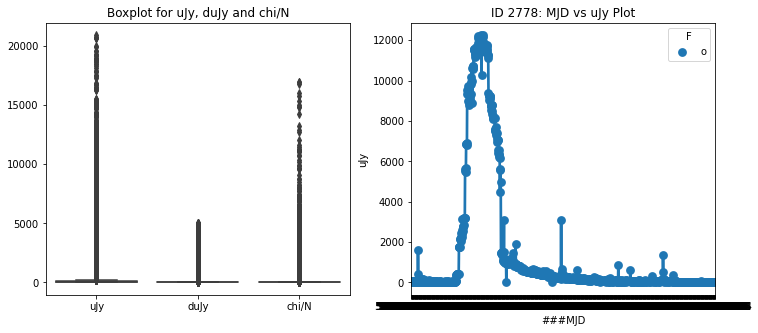

In [36]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
sns.boxplot(data=rawdata1.iloc[:,[1,2,3,4]], ax = ax[0]).set_title("Boxplot for uJy, duJy and chi/N")
sns.pointplot(x=xval1, y=yval1, ci = xerr1, data = erdata1, capsize=3, ax = ax[1], hue = "F").set_title("ID 2778: MJD vs uJy Plot")

<p>The result of the data cleaning are visualised above: <br>
    From the boxplot the data tend to have better boundaries for all the observation.<br> Filtering the data for ID 2778, the plot then showcased the baseline value at uJy = 0. It also showed a period where the value of uJy increased implying supernovae is occuring, followed by the decaying value right after. </p>
    
<p>The next step is to build the feature variables based on the filtered dataset. <br>
    

#  Feature Constructing

<p> Creating features are important as most data analytics algorythm will produce results based on the data provided.<br>
    In this project, the two main features that will be used are:</p>
    
1. Flux value during supernovae(uJy)<br>
2. Duration of the supernova
    
<p>However due to the limitation of astronomical knowledge the following key assumptions used are: </p>

1. Defining the active values/supernova when the flux value is more than 5 times the value of the error<br>
2. The duration is the length of observation when (1) is achieved.<br>
3. The mean value flux is taken as representation for each object.<br>

In [37]:
rawdata1 = rawdata1[rawdata1['uJy'] >= (rawdata1['duJy']*5)]

In [38]:
i = 1
df = pd.DataFrame()
while i <= len(rawdata1.Object.unique()):
    df_temp = rawdata1[rawdata1.Object == i]
    df_temp['duration'] = len(df_temp)
    df = df.append(df_temp)

    i += 1
    

In [39]:
rawdata1 = df

In [40]:
rawdata1 = rawdata1.groupby('uuid')['uJy','duration'].mean()

In [41]:
rawdata1 = rawdata1.reset_index()

The glimpse of the features are as follows:

In [42]:
rawdata1.head(5)

,uuid,uJy,duration
0,2776,202.950495,404.0
1,2777,101.305882,255.0
2,2778,2664.370370,567.0
3,2779,379.125490,255.0
4,2780,560.356371,463.0


# Results and Methodology

The analysis will be using 2 methods:<br>

**1. K-Means Clustering** <br>

K means tend to work well on large sample size and medium number of clusters. It also comes with an elbow method is an algorithm that runs a simulation to determine the best number of cluster

**2. K-Nearest Neighbour (Ward Method)**<br>

This method involves an agglomerative clustering algorithm. it works by repeatedly merging the closest two clusters but use different definitions of the distance between clusters. It is most appropriate for quantitative variables


## K-Means Clustering

In [43]:
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import kneighbors_graph

import matplotlib.image as mpimg

The elbow algorithm results are as follows: <br>
based from the result, it is recommended that the number of cluster is equals to 5

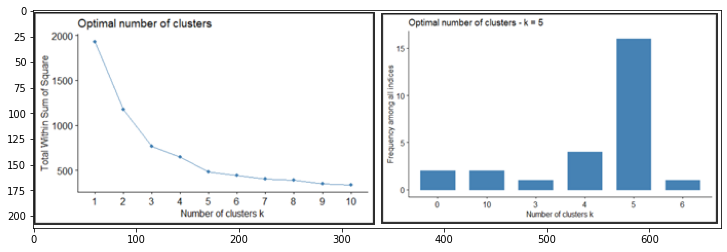

In [44]:
img = mpimg.imread('ElbowMethod.png')
plt.figure(figsize = (15,4))
plt.imshow(img)

In [45]:
kmean = KMeans(n_clusters=5)

In [46]:
rawdata_gp1 = rawdata1.loc[:,['uJy','duration']]

In [47]:
kmean.fit(rawdata_gp1)

KMeans(n_clusters=5)

In [48]:
label_mean = kmean.predict(rawdata_gp1)

In [49]:
plot_mean = pd.DataFrame(rawdata_gp1)

In [50]:
plot_mean['cluster'] = label_mean


In [51]:
plot_mean = plot_mean.rename(columns={0:'uJy',1:'duration'})

In [52]:
plot_mean.cluster = plot_mean.cluster.astype(str)

In [53]:
sample = pd.DataFrame(plot_mean.cluster.value_counts())

Text(0.5, 1.0, 'Classification via K-Means Method')

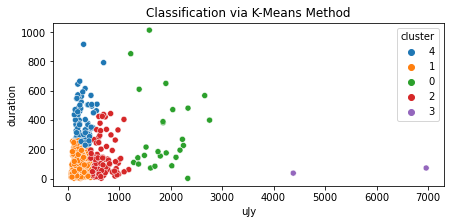

In [60]:
fig, ax = plt.subplots(figsize = (7,3))
sns.scatterplot(x="uJy", y="duration", data = plot_mean, hue = "cluster").set_title("Classification via K-Means Method")

The result of the analysis is presented in the chart above. Based from the plot, there are 1 major cluster 1 which has 418 objects (orange), 3 minor clusters (red, blue and green) which has 115, 85 and 25 objects respectively, and 1 outlier cluster (purple) which only has 2 objects. The uJx value seems to heavily differentiating the clusters. However, the duration tend to separate the cluster Blue and Orange as well as these 2 clusters are having approximately equal value of flux (uJy). <br>

There is also an outlier cluster which only consist of 2 objects, which are uuid 2916 and 2938. These 2 objects have extremely high value of flux which separate them from most of other objects.The duration of these 2 objects are 37 and 72 respectively. Further analysis should be done to study whether the flux value are accurate. There is a possibility that these value of flux are magnified due to the distant of the object are nearer compared to other objects.<br>

next, the data is analysed using the Ward Method. 

## K-Nearest Neighbour (Ward Method)

In [62]:
rawdata_gp2 = rawdata1.loc[:,['uJy','duration']]

In [63]:
connectivity = kneighbors_graph(rawdata_gp2, n_neighbors=5, include_self=False)
    # make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

In [64]:
ward = cluster.AgglomerativeClustering(n_clusters= 5 , linkage='ward',connectivity=connectivity)

In [65]:
ward.fit(rawdata_gp2)

AgglomerativeClustering(connectivity=<645x645 sparse matrix of type '<class 'numpy.float64'>'
	with 3960 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

In [66]:
label_ward = ward.fit_predict(rawdata_gp2)

In [67]:
plot_ward = pd.DataFrame(rawdata_gp2)

In [68]:
plot_ward['cluster'] = label_ward


In [69]:
plot_ward = plot_ward.rename(columns={0:'uJy',1:'duration'})

In [70]:
import plotly.express as px

In [71]:
plot_ward.cluster = plot_ward.cluster.astype(str)

In [72]:
sample_ward = pd.DataFrame(plot_ward.cluster.value_counts())

Text(0.5, 1.0, 'Classification via KNN-Ward Method')

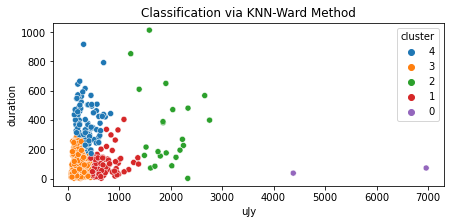

In [73]:
fig, ax = plt.subplots(figsize = (7,3))
sns.scatterplot(x="uJy", y="duration", data = plot_ward, hue = "cluster").set_title("Classification via KNN-Ward Method")

Similar results are observed even when classifying using the Ward Method. The clusters are still consist of 1 Major cluster, 3 minor and 1 outlier clusters. The object distribution for each clusters are similar to the result of K means Algorithm. Hence we can conclude that the classifier method would return the same results if the same data is used as an input.

In [75]:
rawdata1['K-Mean-Cluster'] = label_mean

In [76]:
rawdata1['Ward-Method'] = label_ward

In [82]:
rawdata1.head(5)

,uuid,uJy,duration,K-Mean-Cluster,Ward-Method
0,2776,202.950495,404.0,4,4
1,2777,101.305882,255.0,1,3
2,2778,2664.370370,567.0,0,2
3,2779,379.125490,255.0,4,4
4,2780,560.356371,463.0,4,4


A glimpse of the dataset with their respective clusters are tabled as above. 

# Conclusion

The objects are heavily clustered based on the Flux value (uJy), the duration variable also contribute towards classifying the object however it was less significant. Further analysis to be done on object uuid 2916 and 2938 as the flux value are extremely too high. This value could be biased as the distance of the objects were not considered / included in the calculation during constructing the features. 

In the nutshell, it is recommended to analyse the result in the perspective of astronomical standpoint in order to evaluate the results accuracy. In the case where the classification is inaccurate, the features could be improve by using the provided formula. This could improve the features representation of the flux value and also the duration of the supernova. 



In [81]:
# fig, ax = plt.subplots(1,2,figsize = (14,3))
# sns.scatterplot(x="uJy", y="duration", data = plot_mean, ax = ax[0], hue = "cluster").set_title("Classification via K-Means Method")
# sns.scatterplot(x="uJy", y="duration", data = plot_ward, ax = ax[1], hue = "cluster").set_title("Classification via KNN-Ward Method")